# __Predicting An Article's Popularity Based On Shares__
Samuel Sherman 

July, 2015

##_Data Examination_

In [1]:
import json
import urllib.request, urllib.error, urllib.parse
from aylienapiclient import textapi
c = textapi.Client("22ce6f0d", "86b162153794a745f120de685500c724")

APPLICATION_ID = "22ce6f0d"
APPLICATION_KEY = "86b162153794a745f120de685500c724"

def call_aylien(endpoint, parameters):
  url = 'https://api.aylien.com/api/v1/' + endpoint
  headers = {
      "Accept":                             "application/json",
      "Content-type":                       "application/x-www-form-urlencoded",
      "X-AYLIEN-TextAPI-Application-ID":    APPLICATION_ID,
      "X-AYLIEN-TextAPI-Application-Key":   APPLICATION_KEY
  }
  opener = urllib.request.build_opener()
  request = urllib.request.Request(url,
    urllib.parse.urlencode(parameters).encode('utf-8'), headers)
  response = opener.open(request);
  return json.loads(response.read().decode())

In [2]:
import yaml
import textwrap
import requests
from bs4 import BeautifulSoup, SoupStrainer

mashTop1 = "http://mashable.com/2015/07/21/nasa-more-ice-mountains-pluto/"
mashTop2 = "http://mashable.com/2015/07/21/lindsey-grahams-phone-number/"
mashTop3 = "http://mashable.com/2015/07/21/sepp-blatter-comedian-money/"
mashTop4 = "http://mashable.com/2015/07/21/courts-facebook-new-york/"

mashBot1 = "http://mashable.com/2014/11/10/early-bird-media-summit/"
mashBot2 = "http://mashable.com/2014/11/10/mashies-pics/"
mashBot3 = "http://mashable.com/2014/12/19/chrysler-recall-airbag-2-9-million/"
mashBot4 = "http://mashable.com/2015/01/05/dow-falls-331-points/"

fcbAPI = "https://api.facebook.com/method/links.getStats?urls=%s&format=json"
twtAPI = "http://urls.api.twitter.com/1/urls/count.json?url=%s"



# Mashable top 1
mashTop1soup = urllib.request.urlopen(mashTop1)
mashTop1soup = BeautifulSoup(mashTop1soup)
MT1script = mashTop1soup.script.contents
MT1script = MT1script[0].split(';')[0]
MT1=yaml.load(textwrap.dedent((MT1script).split('=')[1]))

# Mashable top 2
mashTop2soup = urllib.request.urlopen(mashTop2)
mashTop2soup = BeautifulSoup(mashTop2soup)
MT2script = mashTop2soup.script.contents
MT2script = MT2script[0].split(';')[0]
MT2=yaml.load(textwrap.dedent((MT2script).split('=')[1]))

# Mashable top 3
mashTop3soup = urllib.request.urlopen(mashTop3)
mashTop3soup = BeautifulSoup(mashTop3soup)
MT3script = mashTop3soup.script.contents
MT3script = MT3script[0].split(';')[0]
MT3 = yaml.load(textwrap.dedent((MT3script).split('=')[1]))

# Mashable top 4
mashTop4soup = urllib.request.urlopen(mashTop4)
mashTop4soup = BeautifulSoup(mashTop4soup)
MT4script = mashTop4soup.script.contents
MT4script = MT4script[0].split(';')[0]
MT4=yaml.load(textwrap.dedent((MT4script).split('=')[1]))

MT4.keys()

dict_keys(['pub_day', 'content_source_name', 'v_max', 'h_pub', 'age', 'v_buy_i', 'display_mode', 'top_channel', 'content_type', 'campaign', 'h_pub_buy', 'topics', 'content_source_type', 'v_cur', 'post_lead_type', 'v_cur_i', 'pub_year', 'b_flag', 'sourced_from', 'h_buy', 'author_name', 'pub_date', 'events', 'pub_month', 'viral_video_type', 'v_max_i', 'v_buy', 'channel', 'isPostView'])

In [3]:
MT4['pub_date']

'07/22/2015'

In [4]:
import datetime
now = datetime.datetime.now()

print(now)

2015-07-24 15:12:17.397793


In [5]:
MT4['age']

'2'

In [6]:
MT4['channel']

'social-media'

In [7]:
MT4['topics']

'Facebook,new york,social,Social Media,Uncategorized,user data,user privacy'

In [8]:
MT4['content_type']

'article'

After doing some initial analysis of the html code for articles from the Mashable website, it was determined where some features were derived. Specifically, the "script" attribute listed a lot of features that are present in the dataset. One of particular interest was the "age" variable, which appears to be the "timedelta". In comparison to the current time and date, it can be inferred that this represents the total days that have passed since the article was released. This will be an important variable when training the model.   

####Note: Due to complications with the pySpark API and python 3, the remainder of the document will be conducted using python 2

In [9]:
import os.path
baseDir = os.path.join('data')
inputPath = os.path.join('study', 'OnlineNewsPopularity.csv')
fileName = os.path.join(baseDir, inputPath)
numPartitions = 2
rawData = sc.textFile(fileName, numPartitions)
header = rawData.first()
rawData = rawData.filter(lambda x: x != header)
dataFeats = unicode.decode(header).split()

print dataFeats
print len(dataFeats)-3
print dataFeats[60]

[u'url,', u'timedelta,', u'n_tokens_title,', u'n_tokens_content,', u'n_unique_tokens,', u'n_non_stop_words,', u'n_non_stop_unique_tokens,', u'num_hrefs,', u'num_self_hrefs,', u'num_imgs,', u'num_videos,', u'average_token_length,', u'num_keywords,', u'data_channel_is_lifestyle,', u'data_channel_is_entertainment,', u'data_channel_is_bus,', u'data_channel_is_socmed,', u'data_channel_is_tech,', u'data_channel_is_world,', u'kw_min_min,', u'kw_max_min,', u'kw_avg_min,', u'kw_min_max,', u'kw_max_max,', u'kw_avg_max,', u'kw_min_avg,', u'kw_max_avg,', u'kw_avg_avg,', u'self_reference_min_shares,', u'self_reference_max_shares,', u'self_reference_avg_sharess,', u'weekday_is_monday,', u'weekday_is_tuesday,', u'weekday_is_wednesday,', u'weekday_is_thursday,', u'weekday_is_friday,', u'weekday_is_saturday,', u'weekday_is_sunday,', u'is_weekend,', u'LDA_00,', u'LDA_01,', u'LDA_02,', u'LDA_03,', u'LDA_04,', u'global_subjectivity,', u'global_sentiment_polarity,', u'global_rate_positive_words,', u'global

The data represents the different attributes of online news articles and includes a count of shares for that article. There are a total of 61 colmuns in the dataset and the "shares" and "timedelta" features will be used as the dependent variable or label.  Only 58 of the remaining features will be used as predictors for the model. This will not include the "url", which appears to have little relevance.   

##_Data Partition_

In [10]:
# Load appropriate packages
from pyspark.mllib.regression import LabeledPoint 
from pyspark.mllib.linalg import SparseVector
import numpy as np

In [11]:
weights = [.8, .1, .1] # 80% for training and 20% for validation and testing
seed = 42

# Use randomSplit with weights and seed, partition
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)

# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()
numTrain = rawTrainData.count()
numVal = rawValidationData.count()
numTest = rawTestData.count()

print numTrain, numVal, numTest, numTrain + numVal + numTest # Print distribution and total
print rawData.take(1) # Print the features of first element 

31713 3996 3935 39644
[u'http://mashable.com/2013/01/07/amazon-instant-video-browser/, 731.0, 12.0, 219.0, 0.663594466988, 0.999999992308, 0.815384609112, 4.0, 2.0, 1.0, 0.0, 4.6803652968, 5.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 496.0, 496.0, 496.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.500331204081, 0.378278929586, 0.0400046751006, 0.0412626477296, 0.0401225435029, 0.521617145481, 0.0925619834711, 0.0456621004566, 0.013698630137, 0.769230769231, 0.230769230769, 0.378636363636, 0.1, 0.7, -0.35, -0.6, -0.2, 0.5, -0.1875, 0.0, 0.1875, 593']


##_Data Encoding and Model_

I now define three functions to encode the features as categorial. They will be represented in MLlib's SparseVector format. The first will split each element of the RDD by the comma delimiter and return a list of tuples for each feature indexed by its key. The second will index all the parsed data and return all the categories in the entire dataset as a dictionary, where the key is the (index, feature) and the value will be its index realtive to the entire dataset. This will be a dictionary containing all of the distinct categories for the entire dateset. Finally, the third function will encode the categorial features in SparseVector format. All features will be represented as categorial in this case, as all the occurences of any particular feature will still be represented. Therefore, any continuous variables will be appropriately defined.


In [12]:
def parseLine(line):
    p = line.split(', ')
    return [(i-2, p[i]) for i in range(2,len(p)-1)]  

parsedTrainFeat = rawTrainData.map(parseLine)
print parsedTrainFeat.take(1)

[[(0, u'12.0'), (1, u'219.0'), (2, u'0.663594466988'), (3, u'0.999999992308'), (4, u'0.815384609112'), (5, u'4.0'), (6, u'2.0'), (7, u'1.0'), (8, u'0.0'), (9, u'4.6803652968'), (10, u'5.0'), (11, u'0.0'), (12, u'1.0'), (13, u'0.0'), (14, u'0.0'), (15, u'0.0'), (16, u'0.0'), (17, u'0.0'), (18, u'0.0'), (19, u'0.0'), (20, u'0.0'), (21, u'0.0'), (22, u'0.0'), (23, u'0.0'), (24, u'0.0'), (25, u'0.0'), (26, u'496.0'), (27, u'496.0'), (28, u'496.0'), (29, u'1.0'), (30, u'0.0'), (31, u'0.0'), (32, u'0.0'), (33, u'0.0'), (34, u'0.0'), (35, u'0.0'), (36, u'0.0'), (37, u'0.500331204081'), (38, u'0.378278929586'), (39, u'0.0400046751006'), (40, u'0.0412626477296'), (41, u'0.0401225435029'), (42, u'0.521617145481'), (43, u'0.0925619834711'), (44, u'0.0456621004566'), (45, u'0.013698630137'), (46, u'0.769230769231'), (47, u'0.230769230769'), (48, u'0.378636363636'), (49, u'0.1'), (50, u'0.7'), (51, u'-0.35'), (52, u'-0.6'), (53, u'-0.2'), (54, u'0.5'), (55, u'-0.1875'), (56, u'0.0'), (57, u'0.1875'

In [13]:
def toOneHotDict(inputData):
    return inputData.zipWithIndex().collectAsMap()

def oneHotEncoder(rawFeats, OHEDict, numOHEFeats):
    v = []
    for i in rawFeats:
      if i in OHEDict: # To take out unforseen features, not observed in the model
          v += [OHEDict[i]]
    return SparseVector(numOHEFeats, sorted(v), np.ones(len(v)))

In [14]:
newsOHEDict = toOneHotDict(parsedTrainFeat.flatMap(lambda k: k).distinct()) # Unique tuples
numNewsOHEFeats = len(newsOHEDict.keys()) 
print newsOHEDict[(50, u'0.7')]
print numNewsOHEFeats

164284
459681


The next function will use the functions above to transform the features and dependent variable to the appropriate format for training the model. This will be in MLlib's LabeledPoint format, where the features are represented as the SparseVector. The label will be defined as a binary variable, where 1 is defined as a popular article and 0 is not. In this case, the "shares" will be divided by the given "timedelta". 

After, scraping a few articles from the mashable website it was determined that the "age", provided in the html code, is the total days that have passed since the release of the article. This was concluded because articles with today's date provided an age of 0, while an article where 24 hours have passed, provided an age of 1. Therefore, the variable being predicted is the shares per day. This will provide a more accurate measure of the popularity, since as time passes there is more opportunity for shares. 

In [15]:
def parseOHELine(line, OHEDict, numOHEFeats):
    p = line.split(', ')
    label = float(p[60])
    delt = float(p[1])
    val = label/delt
    if val > 50:
                l = 1 # Popular articles 
    else:
                l = 0 # Low popularity
    return LabeledPoint(l, oneHotEncoder(parseLine(line),OHEDict,numOHEFeats))

# Train Data
OHETrainData = rawTrainData.map(lambda line: parseOHELine(line, newsOHEDict, numNewsOHEFeats))
OHETrainData.cache()
print OHETrainData.take(1)

[LabeledPoint(0.0, (459681,[3439,4445,12230,12314,13706,24381,24913,34803,39238,44950,45888,53812,62543,79862,92828,98271,122415,122976,141242,142729,143760,145548,152886,157559,164284,173900,187181,187326,187685,205563,207611,212878,232171,249350,258309,259185,267067,270142,273391,275468,293591,293808,293836,294710,307142,315746,327331,340861,342366,357741,365766,399335,406804,407929,440304,444033,447916,452578],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [16]:
# Validation Data
OHEValData = rawValidationData.map(lambda line: parseOHELine(line, newsOHEDict, numNewsOHEFeats))
OHEValData.cache()
print OHEValData.take(1)

[LabeledPoint(0.0, (459681,[3439,4445,32134,37484,44835,45888,46609,53812,69256,86612,107991,118539,142729,143329,143760,146133,153583,154259,170106,171264,186395,187326,187685,207611,212878,213246,222081,232171,249350,258309,258519,259185,267067,293591,293808,294710,302508,315746,319142,342366,346090,347584,364680,379626,380881,386163,399335,402937,408073,408998,419202,444033],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [17]:
# Test Data
OHETestData = rawTestData.map(lambda line: parseOHELine(line, newsOHEDict, numNewsOHEFeats))
OHETestData.cache()
print OHETestData.take(1)

[LabeledPoint(0.0, (459681,[3439,4445,45888,53812,76410,92443,120034,123611,133845,142729,143760,153547,154259,166575,187326,187685,201297,205563,207611,209517,212878,218038,232171,249350,258309,259185,263561,267067,290214,293591,293808,294710,300451,308224,315746,326986,342366,347584,351078,362857,373113,375879,381253,399335,423473,423514,441346,444033],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [18]:
trainPop = OHETrainData.filter(lambda lp: lp.label == 1).count()
testPop = OHETestData.filter(lambda lp: lp.label == 1).count()
valPop = OHEValData.filter(lambda lp: lp.label == 1).count()
trainTot = OHETrainData.count()
testTot = OHETestData.count()
valTot = OHEValData.count()
print (trainPop+testPop+valPop)/float(trainTot+testTot+valTot)

0.0701997780244


The shares per day for the dataset ranged from values of .002 to 5266, with the majority of the data representing lower shares and being left skewed. Therefore, it was determined that a value of 50 shares/day seems to be good threshold for classification. This represents about 7% of the data. Hence, the model will be predicting whether an article can reach 50 shares per day.  

In [19]:
from pyspark.mllib.classification import LogisticRegressionWithSGD 

# Fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

model0 = LogisticRegressionWithSGD.train(OHETrainData, numIters, regParam=regParam, regType=regType, intercept=includeIntercept)
sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept # Examine five weights and intercept of model

[-0.25844696878527501, -0.24320427408639636, -0.23208345190105475, -0.23118850139949443, -0.2285762823669604] 0.760037241805


##_Log Loss, Error, and ROC Curve_

In [20]:
from math import log

def LogLoss(p, y):
    epsilon = 10e-12 # To keep range between 0 and 1
    if p == 0:
      p = epsilon
    elif p == 1:
      p = p - epsilon
    if y == 1:
      ll = -log(p)
    elif y == 0: 
      ll = -log(1-p)
    return ll

Next, the mean of the training data labels is determined as a measure of the distribution of 1's and 0's in the data. This will be used to calculate the log loss between each label, and consequently a baseline log loss of the training data for comparing with the model.

In [21]:
PopFractionTrain = OHETrainData.map(lambda lp: lp.label).mean()# Fraction of training with class one
print PopFractionTrain

logLossTrBase = OHETrainData.map(lambda lp: LogLoss(PopFractionTrain, lp.label)).mean()
print 'Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase)

0.0698767067133
Baseline Train Logloss = 0.253



The following function will calculate a prediction based on the dot product of the features provided and the weights of the model, plus the intercept. This will initially be evaluated on the training data for computing the log loss between its prediction and labels. 

In [22]:
from math import exp 

def getPred(x, w, intercept):
    rawPrediction = x.dot(w) + intercept 
    return float((1+exp(-rawPrediction))**(-1))

trainingPredictions = OHETrainData.map(lambda lp: getPred(lp.features, model0.weights, model0.intercept))
print trainingPredictions.take(5)

[0.06141924925706309, 0.03453089205428043, 0.03970465601059168, 0.038274428243031164, 0.07011661387747324]


The evaluate function will use a given model to make predictions on a given dataset and compute the log loss. Here, the function will evaluate the training data, which will be compared to the baseline log loss (computed with the mean label). 

In [23]:
def evaluate(model, data):
    p = data.map(lambda lp: getPred(lp.features, model.weights, model.intercept)).collect()
    y = data.map(lambda lp: lp.label).collect()
    logLoss = []
    for i in range(len(p)):
      logLoss.append(LogLoss(p[i], y[i]))
    return np.mean(logLoss) # Mean of log loss between each prediction and label
  
logLossTrLR0 = evaluate(model0, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))

# Examine highest five predictions of training set
probsAndLabelsTrain = OHETrainData.map(lambda lp: (getPred(lp.features, model0.weights, model0.intercept), lp.label))
print probsAndLabelsTrain.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

OHE Features Train Logloss:
	Baseline = 0.253
	LogReg = 0.237
[(0.30923857090126483, 1.0), (0.3024040136118755, 1.0), (0.29975555376416724, 1.0), (0.2992485698998085, 1.0), (0.28793386443161717, 1.0)]


The log loss is now calculated using the validation data and predictions made with the logistic regression model. Additionally, the receiver operating characteristic curve is plotted, providing a depiction of how well the model fit.

In [24]:
logLossValBase = OHEValData.map(lambda lp: LogLoss(PopFractionTrain, lp.label)).mean()
logLossValLR0 = evaluate(model0, OHEValData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, logLossValLR0))

# Examine highest five predictions of validation set
probsAndLabels = OHEValData.map(lambda lp: (getPred(lp.features, model0.weights, model0.intercept), lp.label))
print probsAndLabels.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

OHE Features Validation Logloss:
	Baseline = 0.249
	LogReg = 0.233
[(0.25028712633268757, 1.0), (0.22950761649534104, 1.0), (0.2261279662506253, 1.0), (0.2242863565205038, 1.0), (0.2238043701684888, 1.0)]


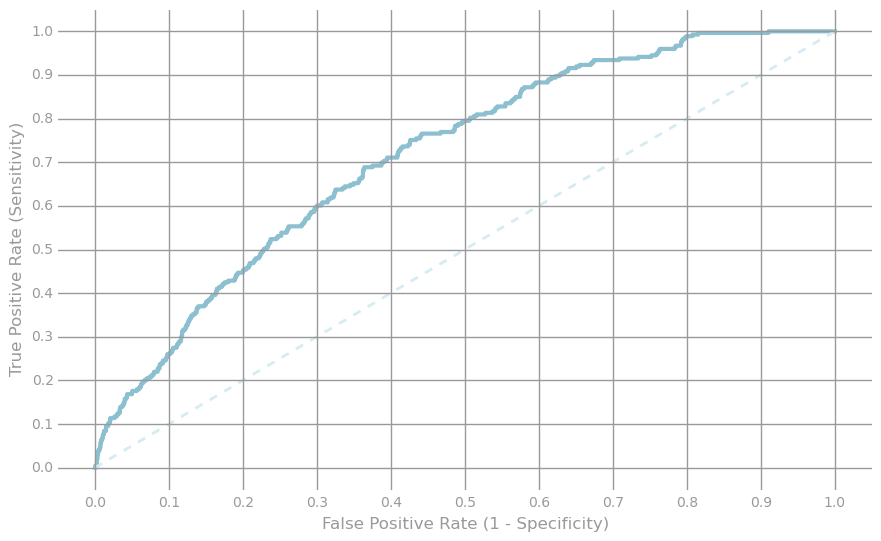

In [25]:
import matplotlib.pyplot as plt


def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

labelsAndScores = OHEValData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model 
pass

In [26]:
def AUC(xdata, ydata):
    x = (np.roll(xdata, -1) - xdata)[:-1]
    y = (np.roll(ydata, -1) + ydata)[:-1]/2
    return sum(map(lambda x, y: x*y, x, y))

# Caluate area under curve
AUCval = AUC(falsePositiveRate, truePositiveRate)
print ('AUC Val Model 0:\n\tLR = {0:.3f}'.format(AUCval))

AUC Val Model 0:
	LR = 0.716


The area under the curve is valued at .72 for the first model and seems appropriate considering the size of the dataset. I would justify this as being a good fit since the model can only be improved through additional data. Considering the mashable dataset has specific features, improving the model with more data would require being able to extract similar features from other sources for online news articles. Additionaly, a sentiment analysis would need to be performed on the text, to determine the polarity and subjectivity.

##_SVM Model_

Using the functions defined above and pySpark's MLlib, the same training data will be used to fit a SVM model.

In [27]:
from pyspark.mllib.classification import SVMWithSGD 

# fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

model1 = SVMWithSGD.train(OHETrainData, numIters, regParam=regParam, regType=regType, intercept=includeIntercept)
sortedWeights = sorted(model1.weights)
print sortedWeights[:5], model1.intercept # Examine last five weights and intercept of model

[-0.24967800090426495, -0.205376683918992, -0.19482328065416371, -0.16877012985973808, -0.16638302063094937] 0.829777324884


In [28]:
trainingPredictions1 = OHETrainData.map(lambda lp: getPred(lp.features, model1.weights, model1.intercept))
print trainingPredictions1.take(5)

[0.15330782119129222, 0.08962066266263051, 0.10648829054464123, 0.09800812461582847, 0.17037179055489454]


In [29]:
logLossTrSVM1 = evaluate(model1, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tSVM = {1:.3f}'
       .format(logLossTrBase, logLossTrSVM1))

OHE Features Train Logloss:
	Baseline = 0.253
	SVM = 0.286


In [30]:
logLossValSVM1 = evaluate(model1, OHEValData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tSVM = {1:.3f}'
       .format(logLossValBase, logLossValSVM1))


probsAndLabels1 = OHEValData.map(lambda lp: (getPred(lp.features, model1.weights, model1.intercept), lp.label))
print probsAndLabels1.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

OHE Features Validation Logloss:
	Baseline = 0.249
	SVM = 0.283
[(0.4352963005605854, 1.0), (0.4166087111962939, 1.0), (0.41268309409525467, 1.0), (0.40769734855181083, 1.0), (0.40507115619378903, 1.0)]


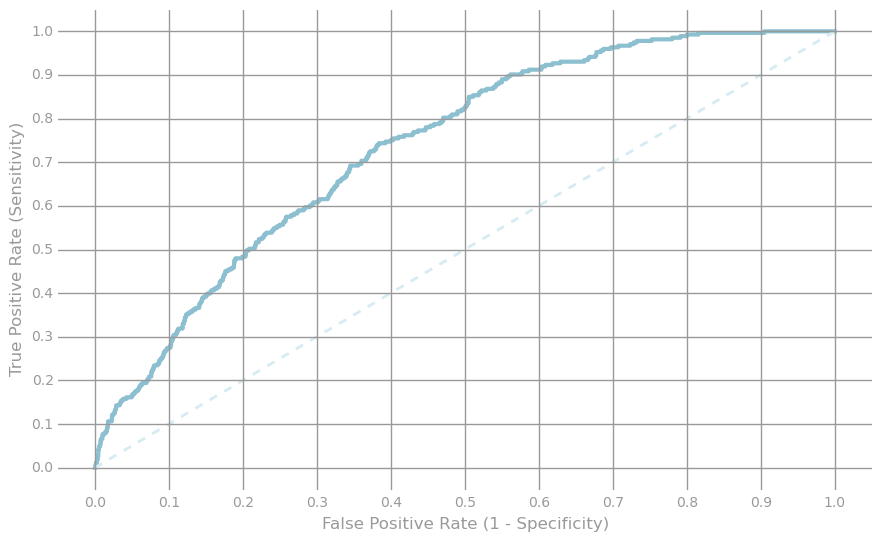

In [31]:
labelsAndScores1 = OHEValData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model1.weights, model1.intercept)))
labelsAndWeights = labelsAndScores1.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model 
pass

In [32]:
AUCval = AUC(falsePositiveRate, truePositiveRate)
print ('AUC Val Model 1:\n\tSVM = {0:.3f}'.format(AUCval))

AUC Val Model 1:
	SVM = 0.736


The SVM model has a slightly improved value for the AUC and so far is the best fit. It will now be plotted against the testing data for final verification.

In [33]:
logLossTestSVM1 = evaluate(model1, OHETestData)
print ('OHE Features Test Logloss:\n\tSVM = {0:.3f}'
       .format(logLossTestSVM1))


probsAndLabelsTest1 = OHETestData.map(lambda lp: (getPred(lp.features, model1.weights, model1.intercept), lp.label))
print probsAndLabelsTest1.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

OHE Features Test Logloss:
	SVM = 0.290
[(0.4772602398436284, 1.0), (0.4674957220029776, 1.0), (0.463044939088234, 1.0), (0.44284890352374007, 1.0), (0.42981684283805777, 1.0)]


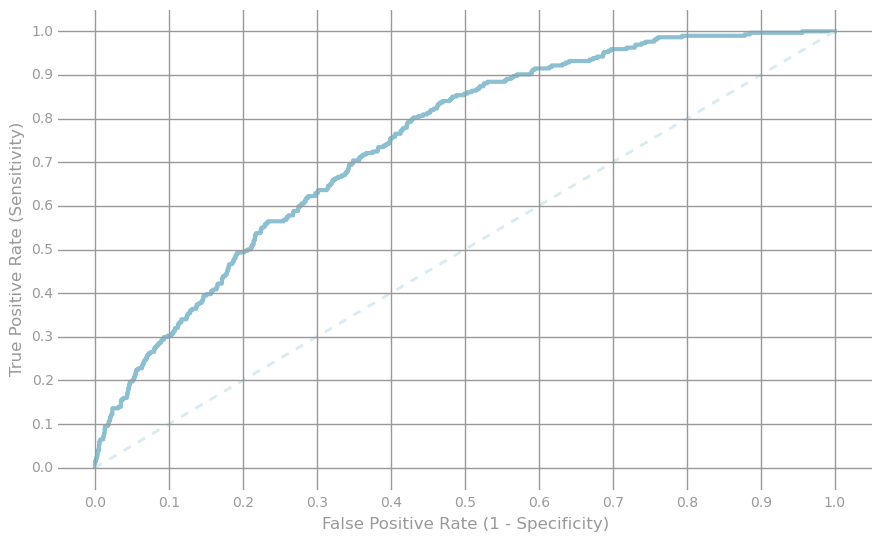

In [34]:
labelsAndScores1 = OHETestData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model1.weights, model1.intercept)))
labelsAndWeights = labelsAndScores1.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model 
pass

In [35]:
AUCtest = AUC(falsePositiveRate, truePositiveRate)
print ('AUC Test Model 1:\n\tSVM = {0:.3f}'.format(AUCtest))

AUC Test Model 1:
	SVM = 0.744


##_Conclusions_
In summary, the approach of fitting classification models to the dataset was appealing. The idea of being able to predict what types of articles are attractive to the public is really quite ambiguous. It seems almost impossible to determine what people will be interested in and for what period of time.  Therefore, the results of the study provide reason to believe that there is potential to implement this type of prediction at a larger scale.  

However, the application of this model at scale could bring about potential problems that could not be taken into account in this model. For example, the time frame for this dataset was about two years (highest “timedelta “ = 731) and is representative of public interest over that time frame. Therefore, using this current model further along in the future might not bring about the best results, as public interest could potentially change.  It would be important to include data that ranges over a longer period. This would help truly identify the key attributes that are most appealing to the public.